In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [18]:
class Conv3x3ReLU(nn.Module):
    def __init__(self, in_channels, out_channels, use_bn=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.use_bn = use_bn
        self.conv = nn.Conv2d(in_channels, out_channels, 3, 1, 0)
        self.batchnorm = nn.BatchNorm2d(out_channels) if use_bn else None
        self.act = nn.ReLU()

    def forward(self, x):
        out = self.conv(x)
        out = self.batchnorm(out) if self.use_bn else out
        out = self.act(out)

        return out 


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_bn=False, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv1 = Conv3x3ReLU(in_channels, out_channels, use_bn)
        self.conv2 = Conv3x3ReLU(out_channels, out_channels, use_bn)

    def forward(self, x):
        out = self.maxpool(x)
        out = self.conv1(out)
        out = self.conv2(out)

        return out


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_bn=False, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = Conv3x3ReLU(in_channels, out_channels*2, use_bn)
        self.conv2 = Conv3x3ReLU(out_channels*2, out_channels*2, use_bn)
        self.up = nn.ConvTranspose2d(out_channels*2, out_channels, 2, 2, 0)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.up(out)

        return out


def custom_center_crop(img, output_size):
    if isinstance(img, torch.Tensor):
        image_height, image_width = img.shape[-2:]
        if isinstance(output_size, int):
            output_size = (output_size, output_size)
        crop_height, crop_width = output_size
        
        crop_top = int((image_height - crop_height) // 2)
        crop_left = int((image_width - crop_width) // 2)
        return img[:, :, crop_top:crop_top+crop_height, crop_left:crop_left+crop_width]
    

class UNet(nn.Module):
    def __init__(self, use_bn=False, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.initial_conv = nn.Sequential(
            Conv3x3ReLU(1, 64, use_bn),
            Conv3x3ReLU(64, 64, use_bn)
        )
        self.down1 = DownBlock(64, 128, use_bn)

        self.down2 = DownBlock(128, 256, use_bn)

        self.down3 = DownBlock(256, 512, use_bn)

        self.down4 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            Conv3x3ReLU(512, 1024, use_bn)
        )

        self.up1 = nn.Sequential(
            Conv3x3ReLU(1024, 1024, use_bn),
            nn.ConvTranspose2d(1024, 512, 2, 2, 0)
        )

        # self.crop1 = transforms.CenterCrop(56)
        self.up2 = UpBlock(1024, 256, use_bn)


        # self.crop2 = transforms.CenterCrop(104)
        self.up3 = UpBlock(512, 128, use_bn)

        # self.crop3 = transforms.CenterCrop(200)
        self.up4 = UpBlock(256, 64, use_bn)

        # self.crop4 = transforms.CenterCrop(392)
        self.final_conv = nn.Sequential(
            Conv3x3ReLU(128, 64, use_bn),
            Conv3x3ReLU(64, 64, use_bn),
            nn.Conv2d(64, 2, 1, 1, 0),
        )


    def forward(self, x):
        initial_conv = self.initial_conv(x)

        down1 = self.down1(initial_conv)

        down2 = self.down2(down1)

        down3 = self.down3(down2)

        bottleneck = self.down4(down3)

        up1 = self.up1(bottleneck)

        up2 = self.up2(torch.cat([custom_center_crop(down3, 56), up1], dim=1))

        up3 = self.up3(torch.cat([custom_center_crop(down2, 104), up2], dim=1))

        up4 = self.up4(torch.cat([custom_center_crop(down1, 200), up3], dim=1))

        final_conv = self.final_conv(torch.cat([custom_center_crop(initial_conv, 392), up4], dim=1))

        return final_conv
    
model = UNet().to(device)
x = torch.zeros(1, 1, 572, 572).to(device)
output = model(x)
output.shape

torch.Size([1, 2, 388, 388])

In [19]:
torch.onnx.export(model, x, 'unet.onnx', input_names=['Input Image Tile'], output_names=['Output Segmentation Map'])

/tmp/ipykernel_47070/2053343871.py:54: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  crop_top = int((image_height - crop_height) // 2)
/tmp/ipykernel_47070/2053343871.py:55: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  crop_left = int((image_width - crop_width) // 2)


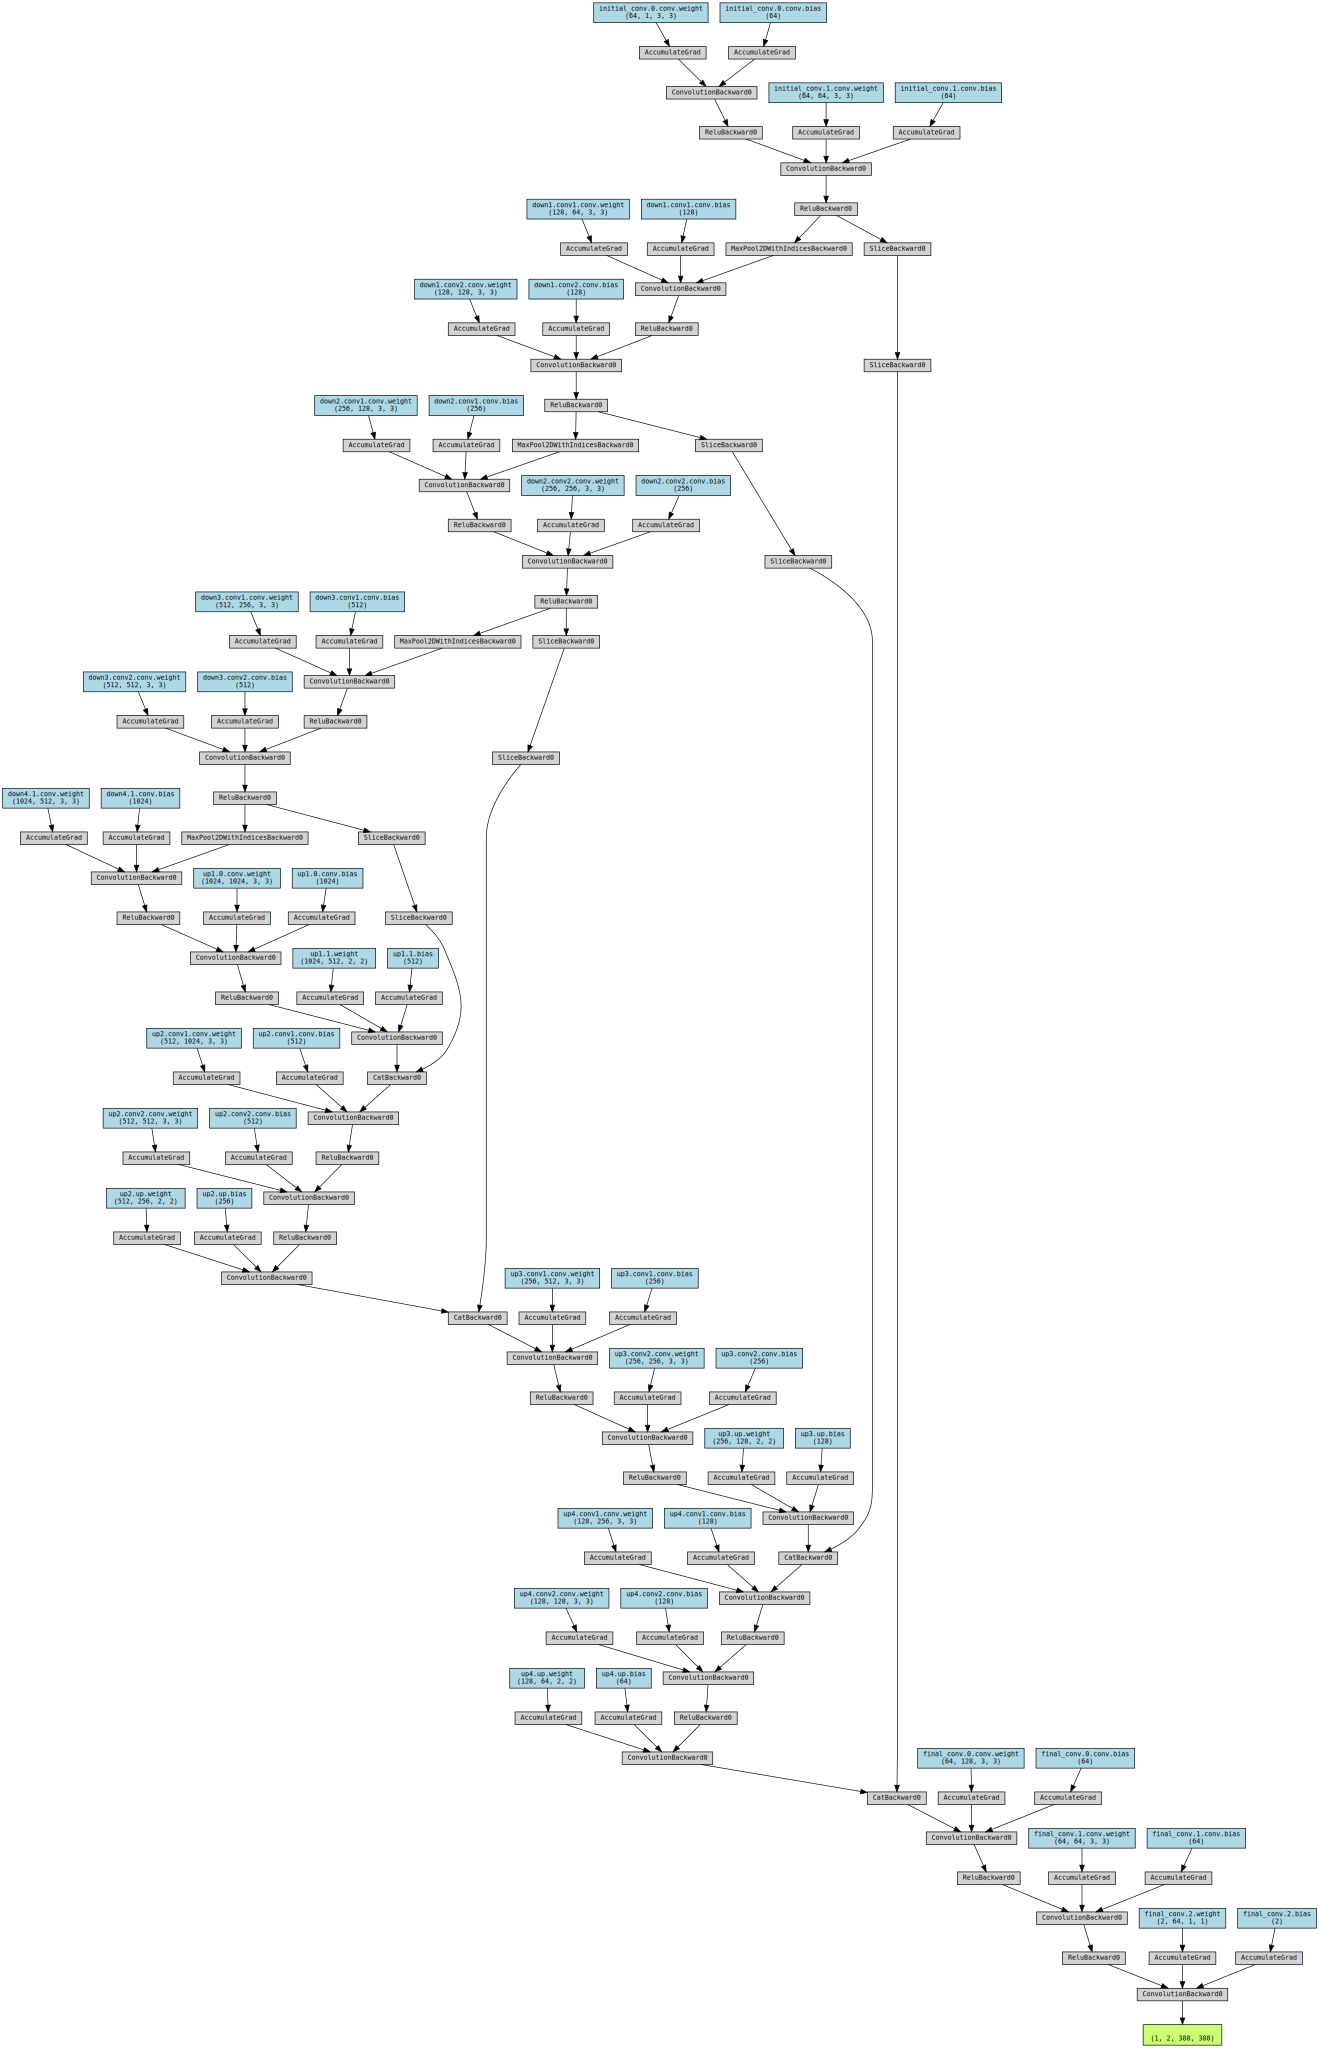

In [5]:
from torchviz import make_dot
make_dot(output, dict(model.named_parameters()))